In [1]:
import pandas as pd
import numpy as np
import os

from typing import List, Tuple

import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

import scipy.stats as st
from scipy.stats import probplot, ks_2samp
import missingno as msno

from scipy.stats import rankdata

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#%matplotlib inline
#import matplotlib.pyplot as plt

import seaborn as sns
#sns.set(color_codes=True)
#sns.set()
#sns.set_palette('husl')

import datetime
import shap
shap.initjs()


#pd.options.display.max_rows=100
#pd.options.display.max_columns=250

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/train_data_complete.csv")
test = pd.read_csv("data/test_data_complete.csv")

In [3]:
# train.info()

In [4]:
# test.info()

In [5]:
gender_na_value = "XNA"
train.gender.fillna(gender_na_value, inplace=True)
test.gender.fillna(gender_na_value, inplace=True)

In [6]:
edu_na_value = "XNA"
train.education_level.fillna(edu_na_value, inplace=True)
test.education_level.fillna(edu_na_value, inplace=True)

In [7]:
famstat_na_value = "Unknown"
train.family_status.fillna(famstat_na_value, inplace=True)
test.family_status.fillna(famstat_na_value, inplace=True)

In [8]:
categorical_feats = test.dtypes[test.dtypes == "object"].index.tolist()

numerical_feats = [colname for colname in train.columns.tolist() if colname not in categorical_feats]
numerical_feats.remove("target")

In [9]:
categorical_feats

['name_contract_type', 'gender', 'education_level', 'family_status']

In [10]:
# numerical_feats

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train[numerical_feats + categorical_feats], train["target"], 
                                                  test_size=0.3, random_state=42)

In [12]:
parameters = {
    "n_estimators": 5000,
    "learning_rate": 0.01,
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 7,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 300,
    "thread_count": 12
}
parameters

{'n_estimators': 5000,
 'learning_rate': 0.01,
 'max_bin': 20,
 'verbose': 10,
 'max_depth': 7,
 'l2_leaf_reg': 10,
 'early_stopping_rounds': 300,
 'thread_count': 12}

In [13]:
# parameters = {
#     "n_estimators": 2000,
#     "learning_rate": 0.01,
#     "max_bin": 10,
#     "verbose": 10,
#     "max_depth": 7,
#     "l2_leaf_reg": 100,
#     "early_stopping_rounds": 50,
#     "thread_count": 12
# }
# parameters

In [14]:
# parameters = {
#     "n_estimators": 1500,
#     "learning_rate": 0.01,
#     "max_bin": 20,
#     "verbose": 10,
#     "max_depth": 8,
#     "l2_leaf_reg": 100,
#     "early_stopping_rounds": 100,
#     "thread_count": 12
# }
# parameters

In [15]:
model = cb.CatBoostClassifier(random_state=42, loss_function="Logloss", eval_metric="AUC", 
                               task_type="CPU", cat_features=categorical_feats, **parameters)

In [16]:
%%time

model.fit(X=X_train, y=y_train,
         eval_set=((X_val, y_val)))

0:	test: 0.6467785	best: 0.6467785 (0)	total: 91.5ms	remaining: 7m 37s
10:	test: 0.7035467	best: 0.7040050 (8)	total: 308ms	remaining: 2m 19s
20:	test: 0.7059574	best: 0.7060805 (18)	total: 530ms	remaining: 2m 5s
30:	test: 0.7066449	best: 0.7068184 (29)	total: 802ms	remaining: 2m 8s
40:	test: 0.7064414	best: 0.7068184 (29)	total: 1.03s	remaining: 2m 4s
50:	test: 0.7073473	best: 0.7073473 (50)	total: 1.23s	remaining: 1m 59s
60:	test: 0.7070506	best: 0.7074689 (51)	total: 1.42s	remaining: 1m 54s
70:	test: 0.7069159	best: 0.7074689 (51)	total: 1.61s	remaining: 1m 52s
80:	test: 0.7078830	best: 0.7079558 (76)	total: 1.85s	remaining: 1m 52s
90:	test: 0.7094665	best: 0.7094665 (90)	total: 2.06s	remaining: 1m 51s
100:	test: 0.7102091	best: 0.7102091 (100)	total: 2.27s	remaining: 1m 49s
110:	test: 0.7110699	best: 0.7110699 (110)	total: 2.48s	remaining: 1m 49s
120:	test: 0.7109004	best: 0.7111059 (115)	total: 2.69s	remaining: 1m 48s
130:	test: 0.7113345	best: 0.7113345 (130)	total: 2.89s	remaini

1120:	test: 0.7308913	best: 0.7308913 (1120)	total: 23.4s	remaining: 1m 20s
1130:	test: 0.7308988	best: 0.7309402 (1128)	total: 23.6s	remaining: 1m 20s
1140:	test: 0.7309094	best: 0.7309402 (1128)	total: 23.8s	remaining: 1m 20s
1150:	test: 0.7309116	best: 0.7309444 (1144)	total: 24s	remaining: 1m 20s
1160:	test: 0.7309887	best: 0.7309913 (1156)	total: 24.2s	remaining: 1m 20s
1170:	test: 0.7310370	best: 0.7310565 (1169)	total: 24.4s	remaining: 1m 19s
1180:	test: 0.7310011	best: 0.7310565 (1169)	total: 24.6s	remaining: 1m 19s
1190:	test: 0.7310199	best: 0.7310565 (1169)	total: 24.8s	remaining: 1m 19s
1200:	test: 0.7310393	best: 0.7310583 (1199)	total: 25s	remaining: 1m 19s
1210:	test: 0.7310499	best: 0.7310845 (1206)	total: 25.2s	remaining: 1m 18s
1220:	test: 0.7310154	best: 0.7310845 (1206)	total: 25.4s	remaining: 1m 18s
1230:	test: 0.7310327	best: 0.7310845 (1206)	total: 25.6s	remaining: 1m 18s
1240:	test: 0.7309595	best: 0.7310845 (1206)	total: 25.8s	remaining: 1m 18s
1250:	test: 0.73

In [17]:
prediction_thread1 = model.predict_proba(test[numerical_feats + categorical_feats])
prediction_thread1

array([[0.95220777, 0.04779223],
       [0.81511192, 0.18488808],
       [0.80898594, 0.19101406],
       ...,
       [0.91316467, 0.08683533],
       [0.98372488, 0.01627512],
       [0.94904586, 0.05095414]])

In [18]:
explainer = shap.TreeExplainer(model)

In [19]:
shap_values = explainer.shap_values(X_train)

In [20]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[0,:], 
    X_train.iloc[0,:],
    link="logit")

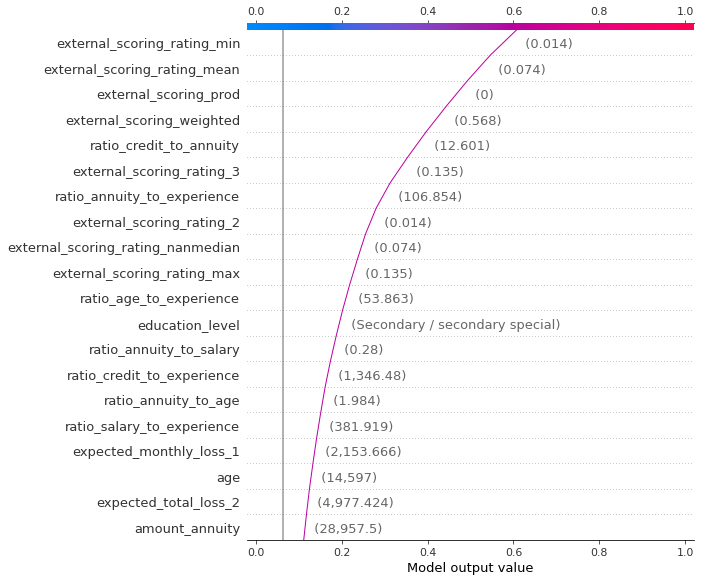

In [21]:
rec_idx = 66472
shap.decision_plot(
    explainer.expected_value,
    shap_values[rec_idx, :],
    X_train.iloc[rec_idx,:],
    link="logit"
)

In [22]:
model.predict_proba(train[numerical_feats + categorical_feats])

array([[0.97303514, 0.02696486],
       [0.89850181, 0.10149819],
       [0.94073762, 0.05926238],
       ...,
       [0.91477624, 0.08522376],
       [0.95731767, 0.04268233],
       [0.92556041, 0.07443959]])

In [23]:
y_pred = pd.DataFrame({
    "prob": model.predict_proba(X_train)[:,1]
})
y_pred.sort_values(by="prob")

,prob
31376,0.004474
72276,0.004840
5733,0.004933
71024,0.004936
35453,0.005020
...,...
66472,0.607676
3926,0.609721
4845,0.610147
12070,0.613073


In [24]:
rec_idx = y_pred[y_pred.prob>0.2][:10].index

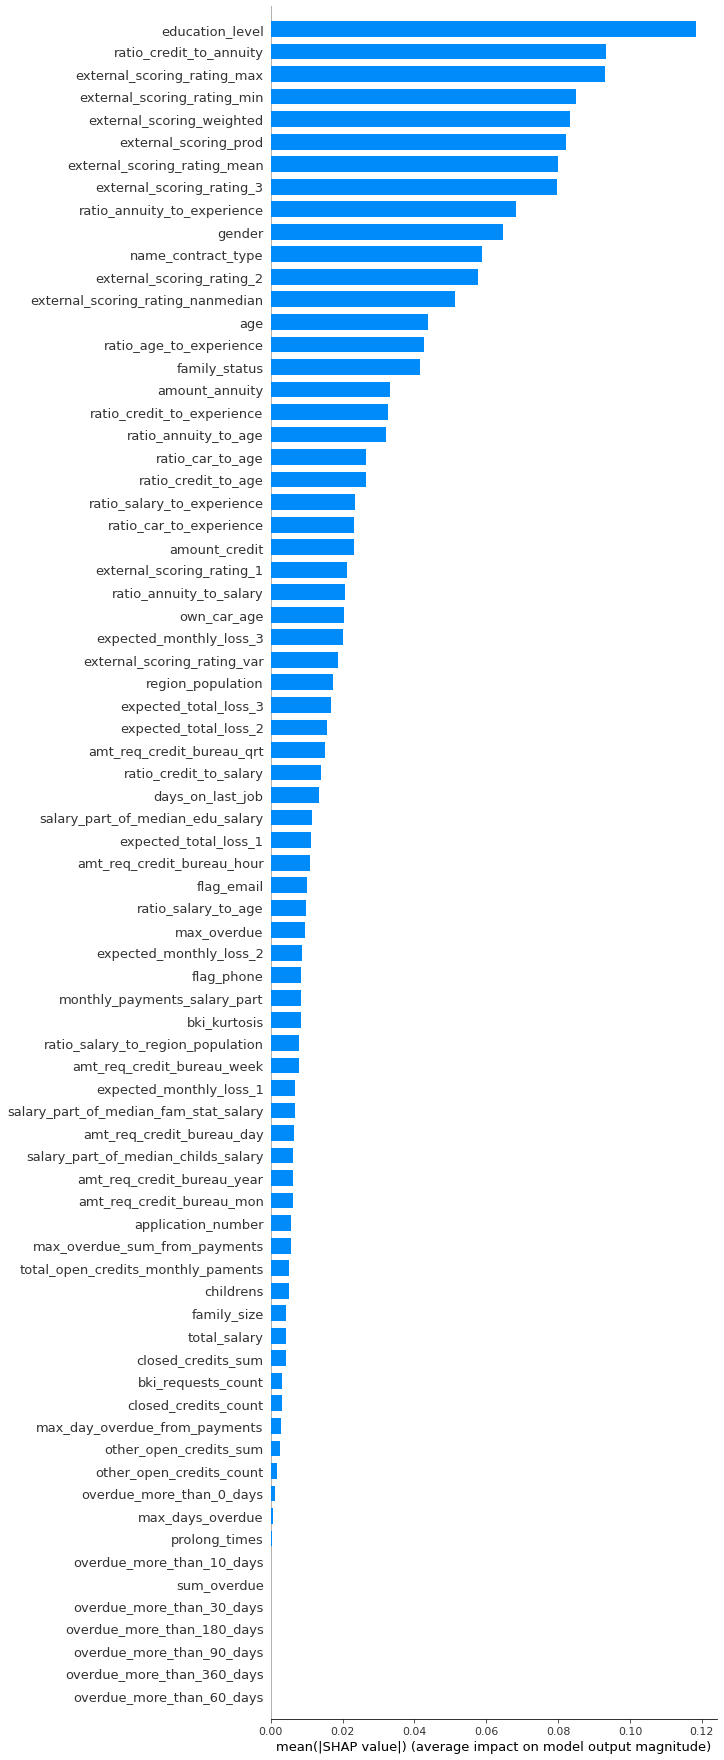

In [25]:
shap.summary_plot(
    shap_values,
    X_train,
    plot_type="bar",
    max_display=1000
)

In [26]:
shap_values_importance = pd.DataFrame({
    "importance": np.abs(shap_values).mean(axis=0),
    "feature": X_train.columns
})
shap_values_importance = shap_values_importance.sort_values(by="importance", ascending=False)
shap_values_importance = shap_values_importance.reset_index(drop=True)
shap_values_importance

,importance,feature
0,0.118337,education_level
1,0.093231,ratio_credit_to_annuity
2,0.093124,external_scoring_rating_max
3,0.085088,external_scoring_rating_min
4,0.083241,external_scoring_weighted
...,...,...
70,0.000110,overdue_more_than_30_days
71,0.000089,overdue_more_than_180_days
72,0.000075,overdue_more_than_90_days
73,0.000025,overdue_more_than_360_days


In [27]:
# features_to_drop = shap_values_importance[shap_values_importance["importance"] < 0.01]
# features_to_drop = features_to_drop.feature.to_list()
# features_to_drop

In [28]:
top25_features = shap_values_importance.loc[0:int(len(shap_values_importance)*0.25)]
top25_features = top25_features.feature.to_list()
top25_features

['education_level',
 'ratio_credit_to_annuity',
 'external_scoring_rating_max',
 'external_scoring_rating_min',
 'external_scoring_weighted',
 'external_scoring_prod',
 'external_scoring_rating_mean',
 'external_scoring_rating_3',
 'ratio_annuity_to_experience',
 'gender',
 'name_contract_type',
 'external_scoring_rating_2',
 'external_scoring_rating_nanmedian',
 'age',
 'ratio_age_to_experience',
 'family_status',
 'amount_annuity',
 'ratio_credit_to_experience',
 'ratio_annuity_to_age']

In [29]:
top50_features = shap_values_importance.loc[0:int(len(shap_values_importance)*0.5)]
top50_features = top50_features.feature.to_list()
top50_features

['education_level',
 'ratio_credit_to_annuity',
 'external_scoring_rating_max',
 'external_scoring_rating_min',
 'external_scoring_weighted',
 'external_scoring_prod',
 'external_scoring_rating_mean',
 'external_scoring_rating_3',
 'ratio_annuity_to_experience',
 'gender',
 'name_contract_type',
 'external_scoring_rating_2',
 'external_scoring_rating_nanmedian',
 'age',
 'ratio_age_to_experience',
 'family_status',
 'amount_annuity',
 'ratio_credit_to_experience',
 'ratio_annuity_to_age',
 'ratio_car_to_age',
 'ratio_credit_to_age',
 'ratio_salary_to_experience',
 'ratio_car_to_experience',
 'amount_credit',
 'external_scoring_rating_1',
 'ratio_annuity_to_salary',
 'own_car_age',
 'expected_monthly_loss_3',
 'external_scoring_rating_var',
 'region_population',
 'expected_total_loss_3',
 'expected_total_loss_2',
 'amt_req_credit_bureau_qrt',
 'ratio_credit_to_salary',
 'days_on_last_job',
 'salary_part_of_median_edu_salary',
 'expected_total_loss_1',
 'amt_req_credit_bureau_hour']

In [30]:
top75_features = shap_values_importance.loc[0:int(len(shap_values_importance)*0.75)]
top75_features = top75_features.feature.to_list()
top75_features

['education_level',
 'ratio_credit_to_annuity',
 'external_scoring_rating_max',
 'external_scoring_rating_min',
 'external_scoring_weighted',
 'external_scoring_prod',
 'external_scoring_rating_mean',
 'external_scoring_rating_3',
 'ratio_annuity_to_experience',
 'gender',
 'name_contract_type',
 'external_scoring_rating_2',
 'external_scoring_rating_nanmedian',
 'age',
 'ratio_age_to_experience',
 'family_status',
 'amount_annuity',
 'ratio_credit_to_experience',
 'ratio_annuity_to_age',
 'ratio_car_to_age',
 'ratio_credit_to_age',
 'ratio_salary_to_experience',
 'ratio_car_to_experience',
 'amount_credit',
 'external_scoring_rating_1',
 'ratio_annuity_to_salary',
 'own_car_age',
 'expected_monthly_loss_3',
 'external_scoring_rating_var',
 'region_population',
 'expected_total_loss_3',
 'expected_total_loss_2',
 'amt_req_credit_bureau_qrt',
 'ratio_credit_to_salary',
 'days_on_last_job',
 'salary_part_of_median_edu_salary',
 'expected_total_loss_1',
 'amt_req_credit_bureau_hour',
 'fl

In [31]:
top100_features = shap_values_importance.feature.to_list()
top100_features

['education_level',
 'ratio_credit_to_annuity',
 'external_scoring_rating_max',
 'external_scoring_rating_min',
 'external_scoring_weighted',
 'external_scoring_prod',
 'external_scoring_rating_mean',
 'external_scoring_rating_3',
 'ratio_annuity_to_experience',
 'gender',
 'name_contract_type',
 'external_scoring_rating_2',
 'external_scoring_rating_nanmedian',
 'age',
 'ratio_age_to_experience',
 'family_status',
 'amount_annuity',
 'ratio_credit_to_experience',
 'ratio_annuity_to_age',
 'ratio_car_to_age',
 'ratio_credit_to_age',
 'ratio_salary_to_experience',
 'ratio_car_to_experience',
 'amount_credit',
 'external_scoring_rating_1',
 'ratio_annuity_to_salary',
 'own_car_age',
 'expected_monthly_loss_3',
 'external_scoring_rating_var',
 'region_population',
 'expected_total_loss_3',
 'expected_total_loss_2',
 'amt_req_credit_bureau_qrt',
 'ratio_credit_to_salary',
 'days_on_last_job',
 'salary_part_of_median_edu_salary',
 'expected_total_loss_1',
 'amt_req_credit_bureau_hour',
 'fl

In [32]:
%%time

# top 25 features model
top25_model = cb.CatBoostClassifier(random_state=42, loss_function="Logloss", eval_metric="AUC", 
                               task_type="CPU", cat_features=categorical_feats, **parameters)

top25_model.fit(X=X_train[top25_features], y=y_train,
         eval_set=((X_val[top25_features], y_val)))

0:	test: 0.6788157	best: 0.6788157 (0)	total: 43.1ms	remaining: 3m 35s
10:	test: 0.7081609	best: 0.7081609 (10)	total: 258ms	remaining: 1m 57s
20:	test: 0.7088242	best: 0.7092009 (17)	total: 442ms	remaining: 1m 44s
30:	test: 0.7098131	best: 0.7098133 (29)	total: 629ms	remaining: 1m 40s
40:	test: 0.7107254	best: 0.7107254 (40)	total: 839ms	remaining: 1m 41s
50:	test: 0.7109600	best: 0.7109600 (50)	total: 1.05s	remaining: 1m 42s
60:	test: 0.7119834	best: 0.7120943 (59)	total: 1.26s	remaining: 1m 41s
70:	test: 0.7120874	best: 0.7123140 (67)	total: 1.53s	remaining: 1m 46s
80:	test: 0.7123453	best: 0.7125979 (78)	total: 1.78s	remaining: 1m 48s
90:	test: 0.7133224	best: 0.7134748 (87)	total: 1.99s	remaining: 1m 47s
100:	test: 0.7134762	best: 0.7136198 (98)	total: 2.22s	remaining: 1m 47s
110:	test: 0.7136943	best: 0.7138149 (106)	total: 2.4s	remaining: 1m 45s
120:	test: 0.7138663	best: 0.7139477 (113)	total: 2.56s	remaining: 1m 43s
130:	test: 0.7140464	best: 0.7140978 (129)	total: 2.74s	remai

1130:	test: 0.7273005	best: 0.7277270 (966)	total: 19.9s	remaining: 1m 8s
1140:	test: 0.7274397	best: 0.7277270 (966)	total: 20.1s	remaining: 1m 8s
1150:	test: 0.7274077	best: 0.7277270 (966)	total: 20.3s	remaining: 1m 7s
1160:	test: 0.7275186	best: 0.7277270 (966)	total: 20.5s	remaining: 1m 7s
1170:	test: 0.7274896	best: 0.7277270 (966)	total: 20.7s	remaining: 1m 7s
1180:	test: 0.7274655	best: 0.7277270 (966)	total: 20.9s	remaining: 1m 7s
1190:	test: 0.7274298	best: 0.7277270 (966)	total: 21.1s	remaining: 1m 7s
1200:	test: 0.7273948	best: 0.7277270 (966)	total: 21.3s	remaining: 1m 7s
1210:	test: 0.7275622	best: 0.7277270 (966)	total: 21.5s	remaining: 1m 7s
1220:	test: 0.7274919	best: 0.7277270 (966)	total: 21.7s	remaining: 1m 7s
1230:	test: 0.7275521	best: 0.7277270 (966)	total: 21.9s	remaining: 1m 7s
1240:	test: 0.7275889	best: 0.7277270 (966)	total: 22.1s	remaining: 1m 6s
1250:	test: 0.7275938	best: 0.7277270 (966)	total: 22.3s	remaining: 1m 6s
1260:	test: 0.7275325	best: 0.7277270 

In [33]:
%%time

# top 50 features model
top50_model = cb.CatBoostClassifier(random_state=42, loss_function="Logloss", eval_metric="AUC", 
                               task_type="CPU", cat_features=categorical_feats, **parameters)

top50_model.fit(X=X_train[top50_features], y=y_train,
         eval_set=((X_val[top50_features], y_val)))

0:	test: 0.6619596	best: 0.6619596 (0)	total: 20.8ms	remaining: 1m 43s
10:	test: 0.7097527	best: 0.7099261 (9)	total: 254ms	remaining: 1m 54s
20:	test: 0.7101974	best: 0.7101974 (20)	total: 471ms	remaining: 1m 51s
30:	test: 0.7105074	best: 0.7106349 (28)	total: 687ms	remaining: 1m 50s
40:	test: 0.7116096	best: 0.7117252 (39)	total: 934ms	remaining: 1m 52s
50:	test: 0.7118632	best: 0.7118632 (50)	total: 1.17s	remaining: 1m 53s
60:	test: 0.7116583	best: 0.7120773 (52)	total: 1.38s	remaining: 1m 51s
70:	test: 0.7126130	best: 0.7126536 (69)	total: 1.58s	remaining: 1m 49s
80:	test: 0.7126765	best: 0.7131644 (74)	total: 1.78s	remaining: 1m 48s
90:	test: 0.7127263	best: 0.7131644 (74)	total: 1.98s	remaining: 1m 46s
100:	test: 0.7132665	best: 0.7133308 (97)	total: 2.2s	remaining: 1m 46s
110:	test: 0.7135478	best: 0.7135646 (109)	total: 2.41s	remaining: 1m 46s
120:	test: 0.7135244	best: 0.7135646 (109)	total: 2.61s	remaining: 1m 45s
130:	test: 0.7137366	best: 0.7138528 (123)	total: 2.83s	remain

1110:	test: 0.7301109	best: 0.7301109 (1110)	total: 23s	remaining: 1m 20s
1120:	test: 0.7299163	best: 0.7302050 (1113)	total: 23.2s	remaining: 1m 20s
1130:	test: 0.7298919	best: 0.7302050 (1113)	total: 23.5s	remaining: 1m 20s
1140:	test: 0.7300382	best: 0.7302050 (1113)	total: 23.7s	remaining: 1m 20s
1150:	test: 0.7299537	best: 0.7302050 (1113)	total: 23.9s	remaining: 1m 19s
1160:	test: 0.7299232	best: 0.7302050 (1113)	total: 24.1s	remaining: 1m 19s
1170:	test: 0.7301463	best: 0.7302050 (1113)	total: 24.3s	remaining: 1m 19s
1180:	test: 0.7299609	best: 0.7302050 (1113)	total: 24.5s	remaining: 1m 19s
1190:	test: 0.7299280	best: 0.7302050 (1113)	total: 24.7s	remaining: 1m 18s
1200:	test: 0.7297910	best: 0.7302050 (1113)	total: 24.9s	remaining: 1m 18s
1210:	test: 0.7300501	best: 0.7302050 (1113)	total: 25.1s	remaining: 1m 18s
1220:	test: 0.7299170	best: 0.7302050 (1113)	total: 25.3s	remaining: 1m 18s
1230:	test: 0.7300640	best: 0.7302050 (1113)	total: 25.5s	remaining: 1m 18s
1240:	test: 0.

In [34]:
%%time

# top 75 features model
top75_model = cb.CatBoostClassifier(random_state=42, loss_function="Logloss", eval_metric="AUC", 
                               task_type="CPU", cat_features=categorical_feats, **parameters)

top75_model.fit(X=X_train[top75_features], y=y_train,
         eval_set=((X_val[top75_features], y_val)))

0:	test: 0.6509969	best: 0.6509969 (0)	total: 120ms	remaining: 9m 57s
10:	test: 0.7058887	best: 0.7067200 (9)	total: 378ms	remaining: 2m 51s
20:	test: 0.7071222	best: 0.7073982 (18)	total: 602ms	remaining: 2m 22s
30:	test: 0.7086540	best: 0.7086540 (30)	total: 828ms	remaining: 2m 12s
40:	test: 0.7095777	best: 0.7095777 (40)	total: 1.04s	remaining: 2m 5s
50:	test: 0.7097116	best: 0.7097940 (48)	total: 1.26s	remaining: 2m 2s
60:	test: 0.7101487	best: 0.7101487 (60)	total: 1.52s	remaining: 2m 3s
70:	test: 0.7102799	best: 0.7103235 (64)	total: 1.74s	remaining: 2m 1s
80:	test: 0.7102004	best: 0.7103812 (79)	total: 1.96s	remaining: 1m 59s
90:	test: 0.7106551	best: 0.7108028 (89)	total: 2.21s	remaining: 1m 59s
100:	test: 0.7110737	best: 0.7111291 (99)	total: 2.44s	remaining: 1m 58s
110:	test: 0.7112130	best: 0.7112801 (107)	total: 2.65s	remaining: 1m 56s
120:	test: 0.7113432	best: 0.7114049 (119)	total: 2.85s	remaining: 1m 54s
130:	test: 0.7120042	best: 0.7120832 (128)	total: 3.06s	remaining:

1120:	test: 0.7299579	best: 0.7299719 (1118)	total: 24.8s	remaining: 1m 25s
1130:	test: 0.7301223	best: 0.7301223 (1130)	total: 25s	remaining: 1m 25s
1140:	test: 0.7301800	best: 0.7301800 (1140)	total: 25.2s	remaining: 1m 25s
1150:	test: 0.7301735	best: 0.7302004 (1144)	total: 25.4s	remaining: 1m 25s
1160:	test: 0.7301626	best: 0.7302005 (1154)	total: 25.7s	remaining: 1m 24s
1170:	test: 0.7302561	best: 0.7302561 (1170)	total: 25.9s	remaining: 1m 24s
1180:	test: 0.7302950	best: 0.7302950 (1180)	total: 26.1s	remaining: 1m 24s
1190:	test: 0.7303459	best: 0.7303578 (1186)	total: 26.3s	remaining: 1m 24s
1200:	test: 0.7302721	best: 0.7303829 (1196)	total: 26.5s	remaining: 1m 23s
1210:	test: 0.7301759	best: 0.7303829 (1196)	total: 26.8s	remaining: 1m 23s
1220:	test: 0.7301157	best: 0.7303829 (1196)	total: 27s	remaining: 1m 23s
1230:	test: 0.7301881	best: 0.7303829 (1196)	total: 27.2s	remaining: 1m 23s
1240:	test: 0.7301241	best: 0.7303829 (1196)	total: 27.4s	remaining: 1m 23s
1250:	test: 0.73

In [35]:
%%time

# top 100 features model
top100_model = cb.CatBoostClassifier(random_state=42, loss_function="Logloss", eval_metric="AUC", 
                               task_type="CPU", cat_features=categorical_feats, **parameters)

top100_model.fit(X=X_train[top100_features], y=y_train,
         eval_set=((X_val[top100_features], y_val)))

0:	test: 0.5659762	best: 0.5659762 (0)	total: 23.1ms	remaining: 1m 55s
10:	test: 0.7014727	best: 0.7024990 (8)	total: 271ms	remaining: 2m 2s
20:	test: 0.7055388	best: 0.7061315 (18)	total: 533ms	remaining: 2m 6s
30:	test: 0.7058004	best: 0.7061315 (18)	total: 798ms	remaining: 2m 7s
40:	test: 0.7060482	best: 0.7061315 (18)	total: 1.01s	remaining: 2m 2s
50:	test: 0.7083136	best: 0.7083136 (50)	total: 1.22s	remaining: 1m 58s
60:	test: 0.7085432	best: 0.7085432 (60)	total: 1.43s	remaining: 1m 55s
70:	test: 0.7090492	best: 0.7090492 (70)	total: 1.64s	remaining: 1m 53s
80:	test: 0.7088910	best: 0.7094031 (72)	total: 1.85s	remaining: 1m 52s
90:	test: 0.7092571	best: 0.7094031 (72)	total: 2.06s	remaining: 1m 50s
100:	test: 0.7097967	best: 0.7098760 (98)	total: 2.27s	remaining: 1m 50s
110:	test: 0.7100829	best: 0.7101065 (109)	total: 2.47s	remaining: 1m 48s
120:	test: 0.7100228	best: 0.7101065 (109)	total: 2.69s	remaining: 1m 48s
130:	test: 0.7105160	best: 0.7105160 (130)	total: 2.9s	remaining:

1130:	test: 0.7303285	best: 0.7303506 (1124)	total: 24.3s	remaining: 1m 23s
1140:	test: 0.7303644	best: 0.7303644 (1140)	total: 24.6s	remaining: 1m 23s
1150:	test: 0.7303621	best: 0.7303781 (1143)	total: 24.8s	remaining: 1m 22s
1160:	test: 0.7303755	best: 0.7303818 (1154)	total: 25s	remaining: 1m 22s
1170:	test: 0.7304049	best: 0.7304049 (1170)	total: 25.2s	remaining: 1m 22s
1180:	test: 0.7304123	best: 0.7304379 (1179)	total: 25.4s	remaining: 1m 22s
1190:	test: 0.7304070	best: 0.7304379 (1179)	total: 25.6s	remaining: 1m 21s
1200:	test: 0.7304125	best: 0.7304400 (1197)	total: 25.8s	remaining: 1m 21s
1210:	test: 0.7304193	best: 0.7304438 (1205)	total: 26.1s	remaining: 1m 21s
1220:	test: 0.7304249	best: 0.7304588 (1214)	total: 26.3s	remaining: 1m 21s
1230:	test: 0.7304510	best: 0.7304817 (1228)	total: 26.5s	remaining: 1m 21s
1240:	test: 0.7304548	best: 0.7304817 (1228)	total: 26.7s	remaining: 1m 20s
1250:	test: 0.7304362	best: 0.7304877 (1242)	total: 26.9s	remaining: 1m 20s
1260:	test: 0.

In [36]:
top25_model_prediction = top25_model.predict_proba(X_val[top25_features])
top50_model_prediction = top50_model.predict_proba(X_val[top50_features])
top75_model_prediction = top75_model.predict_proba(X_val[top75_features])
top100_model_prediction = top100_model.predict_proba(X_val[top100_features])

In [37]:
top25_xtrain_model_prediction = top25_model.predict_proba(X_train[top25_features])
top50_xtrain_model_prediction = top50_model.predict_proba(X_train[top50_features])
top75_xtrain_model_prediction = top75_model.predict_proba(X_train[top75_features])
top100_xtrain_model_prediction = top100_model.predict_proba(X_train[top100_features])

In [38]:
np.corrcoef(
    x=top25_model_prediction[:,1],
    y=top50_model_prediction[:,1]
)

array([[1.        , 0.96762846],
       [0.96762846, 1.        ]])

In [39]:
np.corrcoef(
    x=top50_model_prediction[:,1],
    y=top75_model_prediction[:,1]
)

array([[1.        , 0.98926082],
       [0.98926082, 1.        ]])

In [40]:
np.corrcoef(
    x=top75_model_prediction[:,1],
    y=top100_model_prediction[:,1]
)

array([[1.        , 0.99583418],
       [0.99583418, 1.        ]])

In [41]:
np.corrcoef(
    x=top25_model_prediction[:,1],
    y=top100_model_prediction[:,1]
)

array([[1.        , 0.97201772],
       [0.97201772, 1.        ]])

In [42]:
top25_prediction_score = roc_auc_score(y_val, top25_model_prediction[:,1])
print(f"Top-25 features model X_val prediction score = {round(top25_prediction_score, 5)}")

top50_prediction_score = roc_auc_score(y_val, top50_model_prediction[:,1])
print(f"Top-50 features model X_val prediction score = {round(top50_prediction_score, 5)}")

top75_prediction_score = roc_auc_score(y_val, top75_model_prediction[:,1])
print(f"Top-75 features model X_val prediction score = {round(top75_prediction_score, 5)}")

top100_prediction_score = roc_auc_score(y_val, top100_model_prediction[:,1])
print(f"Top-100 features model X_val prediction score = {round(top100_prediction_score, 5)}")

Top-25 features model X_val prediction score = 0.72817
Top-50 features model X_val prediction score = 0.73077
Top-75 features model X_val prediction score = 0.73046
Top-100 features model X_val prediction score = 0.73082


In [43]:
top25_xtrain_prediction_score = roc_auc_score(y_train, top25_xtrain_model_prediction[:,1])
print(f"Top-25 features model X_train prediction score = {round(top25_xtrain_prediction_score, 5)}")

top50_xtrain_prediction_score = roc_auc_score(y_train, top50_xtrain_model_prediction[:,1])
print(f"Top-50 features model X_train prediction score = {round(top50_xtrain_prediction_score, 5)}")

top75_xtrain_prediction_score = roc_auc_score(y_train, top75_xtrain_model_prediction[:,1])
print(f"Top-75 features model X_train prediction score = {round(top75_xtrain_prediction_score, 5)}")

top100_xtrain_prediction_score = roc_auc_score(y_train, top100_xtrain_model_prediction[:,1])
print(f"Top-100 features model X_train prediction score = {round(top100_xtrain_prediction_score, 5)}")

Top-25 features model X_train prediction score = 0.74514
Top-50 features model X_train prediction score = 0.77082
Top-75 features model X_train prediction score = 0.76488
Top-100 features model X_train prediction score = 0.76575


### Усреднение

In [44]:
amean_oof_preds = top25_model_prediction[:,1] + top50_model_prediction[:,1] + top75_model_prediction[:,1] + top100_model_prediction[:,1]
amean_oof_preds = amean_oof_preds / 4
amean_score = roc_auc_score(y_val, amean_oof_preds)

print(f"Mean: OOF-score = {round(amean_score, 5)}")

Mean: OOF-score = 0.73124


In [45]:
gmean_oof_preds = top25_model_prediction[:,1] * top50_model_prediction[:,1] * top75_model_prediction[:,1] * top100_model_prediction[:,1]
gmean_oof_preds = np.power(gmean_oof_preds,1/4)
gmean_score = roc_auc_score(y_val, gmean_oof_preds)

print(f"GMean: OOF-score = {round(gmean_score, 5)}")

GMean: OOF-score = 0.73126


In [46]:
top25_model_rank = rankdata(top25_model_prediction[:,1])
top50_model_rank = rankdata(top50_model_prediction[:,1])
top75_model_rank = rankdata(top75_model_prediction[:,1])
top100_model_rank = rankdata(top100_model_prediction[:,1])

amean_rank_oof = top25_model_rank + top50_model_rank + top75_model_rank + top100_model_rank
amean_rank_oof = amean_rank_oof / 4

amean_rank_score = roc_auc_score(y_val, amean_rank_oof)
print(f"Mean-ranking: OOF-score = {round(amean_rank_score, 5)}")

Mean-ranking: OOF-score = 0.73107


### Модель второго уровня

In [47]:
top25_model_prediction = top25_model.predict_proba(train[top25_features])
top50_model_prediction = top50_model.predict_proba(train[top50_features])
top75_model_prediction = top75_model.predict_proba(train[top75_features])
top100_model_prediction = top100_model.predict_proba(train[top100_features])

In [48]:
data = pd.DataFrame({
    "top25": top25_model_prediction[:, 1],
    "top50": top50_model_prediction[:, 1],
    "top75": top75_model_prediction[:, 1],
    "top10": top100_model_prediction[:, 1],
    "fmean": (top25_model_prediction[:,1] + top50_model_prediction[:,1] + top75_model_prediction[:,1] + top100_model_prediction[:,1]) / 4,
    "gmean": np.power(top25_model_prediction[:,1] * top50_model_prediction[:,1] * top75_model_prediction[:,1] * top100_model_prediction[:,1],1/4),
    "TARGET": train["target"]
})

In [49]:
data

,top25,top50,top75,top10,fmean,gmean,TARGET
0,0.035864,0.026781,0.029598,0.032357,0.031150,0.030969,0
1,0.086493,0.086353,0.100857,0.100464,0.093542,0.093270,1
2,0.051473,0.060829,0.061730,0.061866,0.058975,0.058805,0
3,0.162753,0.177819,0.186168,0.190442,0.179296,0.178976,1
4,0.086493,0.086353,0.084196,0.084447,0.085372,0.085366,1
...,...,...,...,...,...,...,...
110088,0.086493,0.086353,0.083698,0.084346,0.085223,0.085214,0
110089,0.074383,0.071508,0.067438,0.061836,0.068791,0.068627,0
110090,0.086493,0.086353,0.084899,0.085234,0.085745,0.085742,0
110091,0.052673,0.047824,0.043319,0.046096,0.047478,0.047358,0


In [50]:
second_level_model_feats = data.drop(['TARGET'], axis=1).columns.to_list()
second_level_model_feats

['top25', 'top50', 'top75', 'top10', 'fmean', 'gmean']

In [51]:
X_train, X_val, y_train, y_val = train_test_split(data[second_level_model_feats], data["TARGET"], 
                                                  test_size=0.3, random_state=42)

In [52]:
model = cb.CatBoostClassifier(random_state=42, loss_function="Logloss", eval_metric="AUC", 
                               task_type="CPU", **parameters)

In [53]:
%%time

model.fit(X=X_train, y=y_train,
         eval_set=((X_val, y_val)))

0:	test: 0.7213661	best: 0.7213661 (0)	total: 11.7ms	remaining: 58.6s
10:	test: 0.7298880	best: 0.7298880 (10)	total: 87.7ms	remaining: 39.8s
20:	test: 0.7306351	best: 0.7306351 (20)	total: 161ms	remaining: 38.2s
30:	test: 0.7305594	best: 0.7306706 (21)	total: 242ms	remaining: 38.8s
40:	test: 0.7305797	best: 0.7306706 (21)	total: 320ms	remaining: 38.7s
50:	test: 0.7304409	best: 0.7306706 (21)	total: 426ms	remaining: 41.3s
60:	test: 0.7304217	best: 0.7306706 (21)	total: 515ms	remaining: 41.7s
70:	test: 0.7304157	best: 0.7306706 (21)	total: 583ms	remaining: 40.5s
80:	test: 0.7303707	best: 0.7306706 (21)	total: 671ms	remaining: 40.8s
90:	test: 0.7303133	best: 0.7306706 (21)	total: 790ms	remaining: 42.6s
100:	test: 0.7303190	best: 0.7306706 (21)	total: 863ms	remaining: 41.8s
110:	test: 0.7302248	best: 0.7306706 (21)	total: 934ms	remaining: 41.2s
120:	test: 0.7301519	best: 0.7306706 (21)	total: 1.04s	remaining: 42s
130:	test: 0.7300882	best: 0.7306706 (21)	total: 1.13s	remaining: 42s
140:	t

### Предсказание на test датасете, и усреднение

In [55]:
top25_model_test_data_prediction = top25_model.predict_proba(test[top25_features])
top50_model_test_data_prediction = top50_model.predict_proba(test[top50_features])
top75_model_test_data_prediction = top75_model.predict_proba(test[top75_features])
top100_model_test_data_prediction = top100_model.predict_proba(test[top100_features])

gmean_oof_test_data_preds = top25_model_test_data_prediction[:,1] * top50_model_test_data_prediction[:,1] * top75_model_test_data_prediction[:,1] * top100_model_test_data_prediction[:,1]
gmean_oof_test_data_preds = np.power(gmean_oof_test_data_preds,1/4)

test['TARGET'] = gmean_oof_test_data_preds

# test.head()

submit_result = test[["application_number", "TARGET"]].copy()
submit_result = submit_result.rename(columns={"application_number": "APPLICATION_NUMBER"})
# submit_result.head()

output_filename = "output/%s_PomazanN_submission.csv" % (datetime.datetime.now().strftime("%d.%B.%Y-%I:%M:%S"))
# output_filename

submit_result.to_csv(output_filename, index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f $output_filename -m "another try"


# Score - 0.72231

100%|███████████████████████████████████████| 4.74M/4.74M [00:05<00:00, 972kB/s]
Successfully submitted to GeekBrains Competitive Data Analysis

In [56]:
# top25_model_test_data_prediction = top25_model.predict_proba(test[top25_features])
# top50_model_test_data_prediction = top50_model.predict_proba(test[top50_features])
# top75_model_test_data_prediction = top75_model.predict_proba(test[top75_features])
# top100_model_test_data_prediction = top100_model.predict_proba(test[top100_features])

# data = pd.DataFrame({
#     "top25": top25_model_test_data_prediction[:, 1],
#     "top50": top50_model_test_data_prediction[:, 1],
#     "top75": top75_model_test_data_prediction[:, 1],
#     "top10": top100_model_test_data_prediction[:, 1],
#     "fmean": (top25_model_test_data_prediction[:,1] + top50_model_test_data_prediction[:,1] + top75_model_test_data_prediction[:,1] + top100_model_test_data_prediction[:,1]) / 4,
#     "gmean": np.power(top25_model_test_data_prediction[:,1] * top50_model_test_data_prediction[:,1] * top75_model_test_data_prediction[:,1] * top100_model_test_data_prediction[:,1],1/4),
# })

# test["TARGET"] = model.predict_proba(data)[:, 1]
# test.head()


# submit_result = test[["application_number", "TARGET"]].copy()
# submit_result = submit_result.rename(columns={"application_number": "APPLICATION_NUMBER"})
# # submit_result.head()

# output_filename = "output/%s_PomazanN_submission.csv" % (datetime.datetime.now().strftime("%d.%B.%Y-%I:%M:%S"))
# # output_filename

# submit_result.to_csv(output_filename, index=False)
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f $output_filename -m "another try"


# # Score - 0.72182

In [57]:
# prediction = prediction_thread1
# test['TARGET'] = prediction[:, 1]
# output_filename = "output/%s_PomazanN_submission.csv" % (datetime.datetime.now().strftime("%d.%B.%Y-%I:%M:%S"))
# test[["APPLICATION_NUMBER", "TARGET"]].to_csv(output_filename, index=False)
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f $output_filename -m "another try"